In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import display

%matplotlib inline

In [2]:
tt15 = pd.read_csv("../../../data/cleaned_dfs/tt15.csv")

In [3]:
a = pd.DataFrame(columns = 'one two three'.split())
b = pd.DataFrame(columns = 'one two three'.split())

# test code

In [4]:
def tech_introduced(year_start, year_finish, level = 'code'):

    # file load syntax
    prefix_start, prefix_finish = map(lambda x: str(x)[-2:], [year_start, year_finish])
    path_folder = '~/Google Drive/Oxford/DPhil/future_employment/data/databases/db'
    path_end = '/Tools and Technology.'
    path_start = path_folder + prefix_start + path_end
    path_finish = path_folder + prefix_finish + path_end
    data_type = 'txt'
    
    try:
        # load files
        full_df_before = pd.read_table(path_start + data_type, delimiter = '\t')
    except:
        data_type = 'csv'
        full_df_before = pd.read_csv(path_start + data_type)
    
    try:
        data_type = 'txt'
        full_df_finish = pd.read_table(path_finish + data_type, delimiter = '\t')
    except:
        data_type = 'csv'
        full_df_finish = pd.read_csv(path_finish + data_type)

    # subset files to technology
    full_df_before = full_df_before[full_df_before['T2 Type'] == 'Technology']
    full_df_finish = full_df_finish[full_df_finish['T2 Type'] == 'Technology']

    # limit later year occupations to those available in earlier year
    limited_occupations = full_df_before['O*NET-SOC Code'].unique()
    df_before = full_df_before[full_df_before['O*NET-SOC Code'].isin(limited_occupations)]
    df_finish = full_df_finish[full_df_finish['O*NET-SOC Code'].isin(limited_occupations)]

    # create new dataframe
    df_adoptions = pd.DataFrame(columns = df_finish.columns)
    df_abandons = pd.DataFrame(columns = df_before.columns)

    if level == 'code':
        level = 'Commodity Code'
    else:
        level = 'Commodity Title'
        def clean_title_function(df):
            new_df = df.copy()
            new_df['Commodity Title'] = new_df['Commodity Title'].apply(lambda x: x.lower().strip())
            return new_df
        df_before, df_finish = map(lambda x: clean_title_function(x), [df_before, df_finish])
    
    # find technologies that have emerged
    for occupation_code in limited_occupations:
        df_before_occ_tools = df_before[df_before['O*NET-SOC Code'] == occupation_code]
        df_finish_occ_tools = df_finish[df_finish['O*NET-SOC Code'] == occupation_code]
        adopted = df_finish_occ_tools[~df_finish_occ_tools[level].isin(df_before_occ_tools[level])]
        abandoned = df_before_occ_tools[~df_before_occ_tools[level].isin(df_finish_occ_tools[level])]
        df_adoptions = pd.concat([df_adoptions, adopted])
        df_abandons = pd.concat([df_abandons, abandoned])

    return df_adoptions, df_abandons

In [5]:
adopted, abandoned = tech_introduced(2006, 2015, 'title')

In [6]:
l = [i for i in tt15[tt15['O*NET-SOC Code'] == '11-1021.00']['Commodity Title'].unique()]
l.sort()

In [7]:
l

['access software',
 'accounting software',
 'analytical scientific software',
 'business intelligence data analysis software',
 'calendar scheduling software',
 'computer aided design cad software',
 'computer aided manufacturing cam software',
 'customer relationship management crm software',
 'data base management system software',
 'data base user interface query software',
 'data mining software',
 'desktop calculator',
 'desktop computers',
 'desktop publishing software',
 'development environment software',
 'digital cameras',
 'electronic mail software',
 'enterprise resource planning erp software',
 'enterprise system management software',
 'facilities management software',
 'financial analysis software',
 'graphics photo imaging software',
 'hand trucks accessories',
 'high vacuum equipment',
 'human resources software',
 'internet browser software',
 'inventory management software',
 'magnetic stripe readers encoders',
 'materials requirements planning logistics supply chain

# DIGRESSION: ADOPTION vs. SKILL CHANGE

In [8]:
counts = adopted.groupby('O*NET-SOC Code').count()['T2 Type']
adoptions = pd.DataFrame(counts).reset_index()
adoptions.columns = ['O*NET-SOC Code', 'num_adopted']
log_adoptions = adoptions
log_adoptions['log_num_adopted'] = log_adoptions.num_adopted.apply(np.log)

In [9]:
def load_knowledge(year_before, year_after, column = None):
    path_yb = '../../../data/databases/db' + str(year_before)[-2:] + "/Knowledge.txt"
    path_ya = '../../../data/databases/db' + str(year_after)[-2:] + "/Knowledge.txt"
    
    kb = pd.read_table(path_yb, delimiter = '\t')
    ka = pd.read_table(path_ya, delimiter = '\t')
    
    mutual_occs = set(kb['O*NET-SOC Code']).intersection(set(ka['O*NET-SOC Code']))
    
    kb = kb[kb['O*NET-SOC Code'].isin(mutual_occs)]
    ka = ka[ka['O*NET-SOC Code'].isin(mutual_occs)]

    kb = kb[kb['Scale ID'] == 'LV']
    ka = ka[ka['Scale ID'] == 'LV']
    
    kb = kb.pivot(index = 'O*NET-SOC Code', columns = 'Element Name', values = 'Data Value').reset_index()
    ka = ka.pivot(index = 'O*NET-SOC Code', columns = 'Element Name', values = 'Data Value').reset_index()
    
    if column:
        return kb[['O*NET-SOC Code', column]], ka[['O*NET-SOC Code', column]]
    else:
        return kb, ka

In [11]:
ka, kb = load_knowledge(2007, 2015, 'Clerical')

In [12]:
def diff_func(a, b, type_diff = None):
    if type_diff == 'percent':
        return (a - b)/b
    else:
        return a - b
    
clerical_difference = pd.DataFrame(zip(ka['O*NET-SOC Code'], diff_func(ka['Clerical'], kb['Clerical'], 'percent')), columns = ['O*NET-SOC Code', 'c_diff'])

In [13]:
c_diffs = clerical_difference.merge(log_adoptions, on = 'O*NET-SOC Code', how = 'inner')

In [14]:
mean_c_diffs = c_diffs.groupby('num_adopted').mean().reset_index()

# Test REG Models

In [16]:
import GPy

In [17]:
x = np.array(mean_c_diffs.num_adopted)[:,np.newaxis]
y = np.array(mean_c_diffs.c_diff)[:,np.newaxis]

# x = np.linspace(0, 10, 100)[:,np.newaxis]
# y = np.sin(x) + np.random.normal(0, 1, size = 100)[:,np.newaxis]

Optimization restart 1/15, f = -7.75466398944
Optimization restart 2/15, f = -7.75465511828
Optimization restart 3/15, f = -7.75465864607
Optimization restart 4/15, f = -7.75466023722
Optimization restart 5/15, f = -7.75465890622
Optimization restart 6/15, f = -7.75466255954
Optimization restart 7/15, f = -7.75466297572
Optimization restart 8/15, f = -7.7546580915
Optimization restart 9/15, f = -7.75466050582
Optimization restart 10/15, f = -7.75466305061
Optimization restart 11/15, f = -7.75466398477
Optimization restart 12/15, f = -7.75466198269
Optimization restart 13/15, f = -7.75466398003
Optimization restart 14/15, f = -7.75466398943
Optimization restart 15/15, f = -7.75466294258


 :0: FutureWarning:IPython widgets are experimental and may change in the future.


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x105caa690>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x10e47ba50>],
  [<matplotlib.lines.Line2D at 0x105cbafd0>]]}

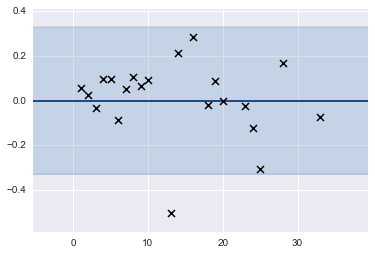

In [18]:
kern = GPy.kern.RBF(input_dim = 1., lengthscale=10., variance=1.,)
m = GPy.models.GPRegression(x, y, kernel = kern)
m.rbf.lengthscale.constrain_bounded(lower = 9, upper = 10)
m.optimize_restarts(15)
m.optimize(messages = True)
m.plot()

In [19]:
from sklearn.linear_model import Ridge

In [20]:
r = Ridge()
r.fit(x, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [21]:
b, m = r.intercept_, r.coef_[0]
f = lambda x: b + m*x

 /Users/Logan/anaconda/envs/dev/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


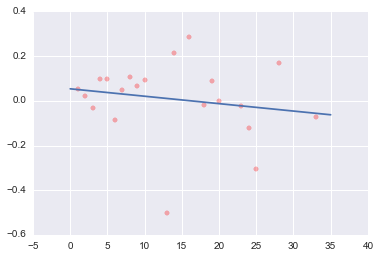

In [22]:
xspace = np.linspace(0, 35, 1000)[:,np.newaxis]
# yspace = r.predict(xspace.T)
a = sns.plt.figure()
sns.plt.xlim = [-1, 36]
sns.plt.plot(xspace, f(xspace))
sns.plt.scatter(x, y, alpha = 0.3, color = 'r')

# RETURN: TECHNOLOGY

In [23]:
tt06 = pd.read_csv('~/Google Drive/Oxford/DPhil/future_employment/data/databases/db06/Tools and Technology.csv')

In [24]:
tt06[tt06['Commodity Title'].apply(lambda x: 'Graphic' in x)]

,Commodity Code,O*NET-SOC Code,O*NET-SOC Title,T2 Type,T2 Example,Commodity Title
45,43232102,11-2011.00,Advertising and Promotions Managers,Technology,Adobe Systems Adobe Illustrator,Graphics or photo imaging software
51,43232102,11-2011.00,Advertising and Promotions Managers,Technology,Graphics software,Graphics or photo imaging software
68,43232102,11-2021.00,Marketing Managers,Technology,Graphic presentation software,Graphics or photo imaging software
97,43232102,11-2031.00,Public Relations Managers,Technology,Adobe Systems Adobe Illustrator,Graphics or photo imaging software
155,43232102,11-3021.00,Computer and Information Systems Managers,Technology,Graphics editor software,Graphics or photo imaging software
184,43232404,11-3021.00,Computer and Information Systems Managers,Technology,Tk software,Graphical user interface development software
252,43232102,11-3041.00,Compensation and Benefits Managers,Technology,Adobe Systems Adobe Illustrator,Graphics or photo imaging software
298,43232102,11-3042.00,Training and Development Managers,Technology,Adobe Systems Adobe Illustrator,Graphics or photo imaging software
390,43232102,11-3071.01,Transportation Managers,Technology,Graphics software,Graphics or photo imaging software
663,43232102,11-9111.00,Medical and Health Services Managers,Technology,ConceptDraw software,Graphics or photo imaging software


In [25]:
tasks = pd.read_table('../../../data/databases/db15/Task Ratings.txt', delimiter = '\t')
tasks = tasks[tasks['Scale ID'] == 'IM']
s_o_codes = pd.read_csv('../../../data/helpers/survey_occs.csv')
# tasks = tasks.groupby('O*NET-SOC Code')
tasks = tasks[tasks['O*NET-SOC Code'].isin(s_o_codes['O*NET-SOC Code'])]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ebfc0d0>]], dtype=object)

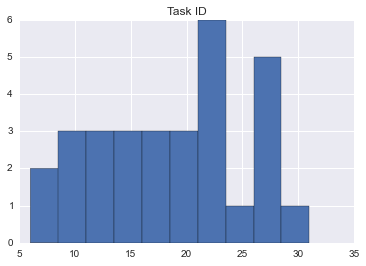

In [26]:
tasks[['O*NET-SOC Code', 'Task ID']].groupby('O*NET-SOC Code').count().hist()

In [27]:
tasks

,O*NET-SOC Code,Task ID,Scale ID,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Date,Domain Source
7,11-1011.00,8823,IM,n/a,4.54,78,0.08,4.38,4.71,N,07/2014,Incumbent
16,11-1011.00,8831,IM,n/a,4.48,82,0.08,4.31,4.65,N,07/2014,Incumbent
25,11-1011.00,8825,IM,n/a,4.40,86,0.10,4.21,4.59,N,07/2014,Incumbent
34,11-1011.00,8826,IM,n/a,4.39,84,0.07,4.24,4.54,N,07/2014,Incumbent
43,11-1011.00,8827,IM,n/a,4.17,76,0.12,3.93,4.42,N,07/2014,Incumbent
52,11-1011.00,8824,IM,n/a,4.15,86,0.14,3.88,4.43,N,07/2014,Incumbent
61,11-1011.00,8836,IM,n/a,4.12,85,0.09,3.94,4.29,N,07/2014,Incumbent
70,11-1011.00,8832,IM,n/a,4.02,68,0.13,3.76,4.28,N,07/2014,Incumbent
79,11-1011.00,8835,IM,n/a,3.96,76,0.12,3.73,4.20,N,07/2014,Incumbent
88,11-1011.00,8833,IM,n/a,3.96,65,0.11,3.73,4.19,N,07/2014,Incumbent


In [28]:
tasks

,O*NET-SOC Code,Task ID,Scale ID,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Date,Domain Source
7,11-1011.00,8823,IM,n/a,4.54,78,0.08,4.38,4.71,N,07/2014,Incumbent
16,11-1011.00,8831,IM,n/a,4.48,82,0.08,4.31,4.65,N,07/2014,Incumbent
25,11-1011.00,8825,IM,n/a,4.40,86,0.10,4.21,4.59,N,07/2014,Incumbent
34,11-1011.00,8826,IM,n/a,4.39,84,0.07,4.24,4.54,N,07/2014,Incumbent
43,11-1011.00,8827,IM,n/a,4.17,76,0.12,3.93,4.42,N,07/2014,Incumbent
52,11-1011.00,8824,IM,n/a,4.15,86,0.14,3.88,4.43,N,07/2014,Incumbent
61,11-1011.00,8836,IM,n/a,4.12,85,0.09,3.94,4.29,N,07/2014,Incumbent
70,11-1011.00,8832,IM,n/a,4.02,68,0.13,3.76,4.28,N,07/2014,Incumbent
79,11-1011.00,8835,IM,n/a,3.96,76,0.12,3.73,4.20,N,07/2014,Incumbent
88,11-1011.00,8833,IM,n/a,3.96,65,0.11,3.73,4.19,N,07/2014,Incumbent


# TASKS

In [29]:
tasks = pd.read_table('../../../data/databases/db15/Task Ratings.txt', delimiter = '\t')
tasks = tasks[tasks['Scale ID'] == 'IM']

In [30]:
s_o_codes = pd.read_csv('../../../data/helpers/survey_occs.csv')
tasks = tasks.groupby('O*NET-SOC Code').head(5)
tasks = tasks[tasks['O*NET-SOC Code'].isin(s_o_codes['O*NET-SOC Code'])].groupby('O*NET-SOC Code').head(5)

In [31]:
task_ref = pd.read_table('../../../data/databases/db15/Tasks to DWAs.txt', delimiter = '\t')
task_ref = task_ref[['Task ID', 'DWA ID']].drop_duplicates(subset = 'Task ID') ##!!! MAY NOT NEED TO DROP DUPLICATES HERE

In [32]:
tasks_dwas = tasks.merge(task_ref, on = 'Task ID', how = 'inner')

In [33]:
level = 'WA'

if level == 'WA':
    full_level = 'WA Name'
else:
    full_level = 'IWA Title'

In [34]:
was = pd.read_csv("../../../data/helpers/work_activities.csv")
tasks_shared = tasks_dwas.merge(was[[full_level, 'DWA ID']])

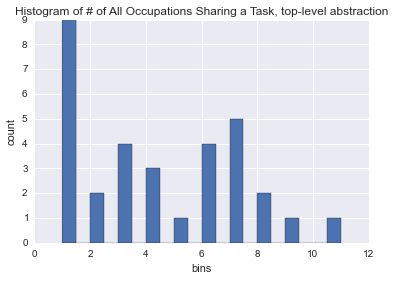

In [35]:
hist = tasks_shared.groupby(full_level).count()['Task ID'].hist(bins = 20)
hist.set_xlabel('bins')
hist.set_ylabel('count')
hist.set_title('Histogram of # of All Occupations Sharing a Task, top-level abstraction')
fig = hist.get_figure()
fig.savefig('WA groupings all occupations.png')

In [36]:
was['WA Name'].unique()

array(['Getting Information',
       'Monitor Processes, Materials, or Surroundings',
       'Identifying Objects, Actions, and Events',
       'Inspecting Equipment, Structures, or Material',
       'Estimating the Quantifiable Characteristics of Products, Events, or Information',
       'Judging the Qualities of Things, Services, or People',
       'Processing Information',
       'Evaluating Information to Determine Compliance with Standards',
       'Analyzing Data or Information',
       'Making Decisions and Solving Problems', 'Thinking Creatively',
       'Updating and Using Relevant Knowledge',
       'Developing Objectives and Strategies',
       'Scheduling Work and Activities',
       'Organizing, Planning, and Prioritizing Work',
       'Performing General Physical Activities',
       'Handling and Moving Objects', 'Controlling Machines and Processes',
       'Operating Vehicles, Mechanized Devices, or Equipment',
       'Interacting With Computers',
       'Repairing and M

# DIGRESSION: Jobs & Wages

In [37]:
occs = pd.read_csv('../../../data/helpers/survey_occs.csv')
occs['O*NET-SOC Code'] = occs['O*NET-SOC Code'].apply(lambda x: str(x)[:-3])
ed = pd.read_csv('../../../data/education/occ_stats.csv').iloc[:-1,:]

In [38]:
survey_occs = ed[ed.code.isin(occs['O*NET-SOC Code'])]

In [39]:
survey_occs.medwage.apply(lambda x: float(x.replace('$','').replace(',',''))).mean()

53820.0

In [40]:
def fix_wage(w):
    try:
        return float(w.replace('$','').replace(',',''))
    except:
        return None

ed.medwage.apply(lambda x: fix_wage(x)).mean()

49460.09276437848

# BACK TO SKILLS

In [41]:
s = pd.read_table('../../../data/databases/db15/Skills.txt', delimiter = '\t')

 /Users/Logan/anaconda/envs/dev/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning:Columns (5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.


In [42]:
s = s[s['Scale ID'] == 'IM']
s = s.pivot_table(values = 'Data Value', index = 'O*NET-SOC Code', columns='Element Name').reset_index()

In [43]:
for i in sorted(s.columns):
    print i

Active Learning
Active Listening
Complex Problem Solving
Coordination
Critical Thinking
Equipment Maintenance
Equipment Selection
Installation
Instructing
Judgment and Decision Making
Learning Strategies
Management of Financial Resources
Management of Material Resources
Management of Personnel Resources
Mathematics
Monitoring
Negotiation
O*NET-SOC Code
Operation Monitoring
Operation and Control
Operations Analysis
Persuasion
Programming
Quality Control Analysis
Reading Comprehension
Repairing
Science
Service Orientation
Social Perceptiveness
Speaking
Systems Analysis
Systems Evaluation
Technology Design
Time Management
Troubleshooting
Writing


# DR Method 1: heuristic

In [44]:
from helpers.helper import *

In [45]:
pctiles = get_percentiles(s.iloc[:,1:])

In [46]:
codes = s['O*NET-SOC Code']

In [47]:
humanized = ["Active Listening",
"Complex Problem Solving",
"Judgment and Decision Making",
"Negotiation",
"Persuasion",
"Science",
"Service Orientation",
"Social Perceptiveness"]

dehumanized = ["Instructing",
"Equipment Maintenance",
"Equipment Selection",
"Management of Financial Resources",
"Management of Material Resources",
"Management of Personnel Resources",
"Monitoring",
"Coordination"]

In [48]:
p_human = pctiles[humanized]
p_dehuman = pctiles[dehumanized]

In [49]:
avg_human = p_human.mean(axis = 1)
avg_dehuman = p_dehuman.mean(axis = 1)

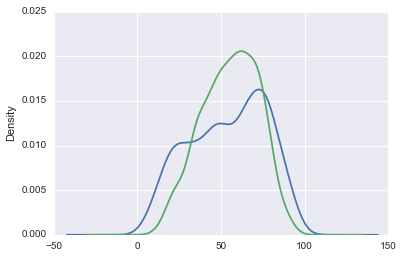

In [50]:
avg_human.plot(kind = 'kde')
avg_dehuman.plot(kind = 'kde')

In [51]:
df_human = pd.DataFrame(zip(codes, avg_human), columns = ['O*NET-SOC Code', 'avg'])
df_dehuman = pd.DataFrame(zip(codes, avg_dehuman), columns = ['O*NET-SOC Code', 'avg'])

df_human = df_human.merge(log_adoptions, on = 'O*NET-SOC Code', how = 'inner')
df_dehuman = df_dehuman.merge(log_adoptions, on = 'O*NET-SOC Code', how = 'inner')

In [52]:
from sklearn.linear_model import LinearRegression

def calc_x_average(df, x_var_name, y_var_name):
    ss = df[[x_var_name, y_var_name]]
    return ss.groupby(x_var_name).mean().reset_index()

def plot_adoption_vs_qualities(df, x_var_name, y_var_name):
    # linear model
    avgs = calc_x_average(df, x_var_name, y_var_name)
    x, y = avgs[x_var_name][:,np.newaxis], avgs[y_var_name]
    
    lm = LinearRegression()
    lm.fit(x, y)
    
    b, m = lm.intercept_, lm.coef_
    f = lambda x: b + m*x
    reg_points = np.array(zip(x, f(x)))
    reg_x, reg_y = reg_points[:,0], reg_points[:,1]
    
    sns.plt.scatter(df[x_var_name], df[y_var_name], color = 'blue', label = 'data')
    sns.plt.plot(avgs[x_var_name], avgs[y_var_name], color = 'red', ls = '--', label = 'discrete average')
    sns.plt.plot(reg_x, reg_y, color = 'g', ls = '--', label = 'mean trend line')
    sns.plt.legend()

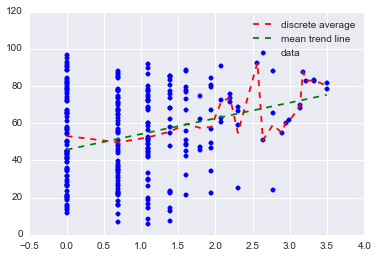

In [57]:
plot_adoption_vs_qualities(df_human, 'log_num_adopted', 'avg')

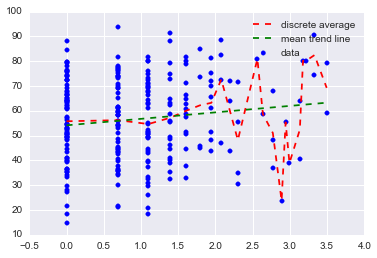

In [58]:
plot_adoption_vs_qualities(df_dehuman, 'log_num_adopted', 'avg')

# DR Method 2: PCA

In [60]:
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components = 2)

In [62]:
X_s = s.iloc[:,1:]

In [63]:
pca.fit(X_s, y)

PCA(copy=True, n_components=2, whiten=False)

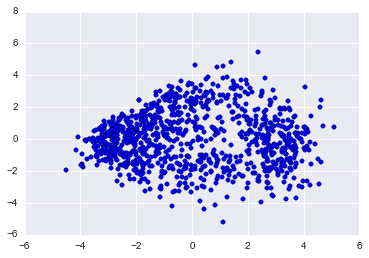

In [65]:
pca_results = pca.fit_transform(X_s, y)
x1, x2 = pca_results[:,0], pca_results[:,1]
sns.plt.scatter(x1, x2)

In [66]:
pts3d = pd.DataFrame(zip(codes, x1, x2), columns = ['O*NET-SOC Code', 'x1', 'x2'])
pts3d = log_adoptions.merge(pts3d, on = 'O*NET-SOC Code', how = 'inner')
xs, ys, zs = pts3d.x1, pts3d.x2, pts3d.num_adopted

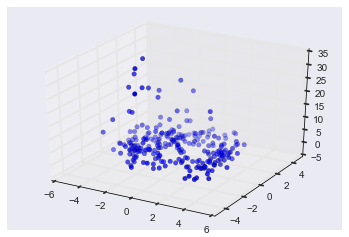

In [67]:
from mpl_toolkits.mplot3d import Axes3D
fig = sns.plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)

In [77]:
np.corrcoef(xs, zs)

array([[ 1.        , -0.26354499],
       [-0.26354499,  1.        ]])

In [72]:
zip(X_s.columns, pca.components_[0])

[('Active Learning', -0.16453041112612343),
 ('Active Listening', -0.15818020379911102),
 ('Complex Problem Solving', -0.13032773705632167),
 ('Coordination', -0.10135031411587457),
 ('Critical Thinking', -0.1341933504157819),
 ('Equipment Maintenance', 0.29949089724971489),
 ('Equipment Selection', 0.22469337961529628),
 ('Installation', 0.10874503593085864),
 ('Instructing', -0.16545612545516808),
 ('Judgment and Decision Making', -0.12881112447890672),
 ('Learning Strategies', -0.16513104605175127),
 ('Management of Financial Resources', -0.088479996126442736),
 ('Management of Material Resources', -0.052049005237467479),
 ('Management of Personnel Resources', -0.12377478031172724),
 ('Mathematics', -0.10495496153917258),
 ('Monitoring', -0.077042401272286579),
 ('Negotiation', -0.14908893730334699),
 ('Operation Monitoring', 0.23087982222343484),
 ('Operation and Control', 0.30153482660219294),
 ('Operations Analysis', -0.12957874006711029),
 ('Persuasion', -0.15674794356113575),
 